# Trabajo: Evaluación de la segmentación

Alumno: Óscar Martínez Olmos

Segmentar por bloques de edificios imagenes satelitales o por trama urbana.

En este trabajo se pretende encontrar una forma de poder separar dos tipos de tramas urbanas presentes en ciudades a partir de una imágen por satelite. Para ello se diferencian dos tipos. El primer tipo es el atomístico, caracterízado por una falta de planeamiento urbano en el cual las calles siguen diferentes direcciones o existen pocos cruces de 4 ejes. El otro tipo el formal, caracterízado por ser muy regular, con calles paralelas sin culs de sac y cruces de 4 ejes.

Se pretende demostrar que una caracterización por textura sería util para diferenciar este tipo de asentamientos urbanos sin necesidad de otras herramientas.

A continuación se importar las clases mínimas necesarias para ejecutar el resto del código y funciones de utilidad.



In [145]:
# Para realizar operacione sobre matrices
import numpy as np
# Para procesar las imágenes
from skimage import data, filters, feature, io, morphology, util, measure
from skimage.filters import rank
# Para mostrar las imágenes
import matplotlib.pyplot as plt
# Paquetes necesarios para la conversion de imágenes de color a escala de grises
from skimage.color import rgb2gray
# Paquetes necesarios para la morfologia matemática
from skimage.morphology import erosion, dilation, opening, closing
# Elementos estructurales
from skimage.morphology import disk, diamond, ball, rectangle, square
# Rellenado de agujeros
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops
from skimage import data
import cv2
import numpy as np
from skimage.feature import greycomatrix, greycoprops
from skimage import data
import cv2

def plot_comparison(img_l, img_m, r_title, m_title):
    """
    Función para mostrar dos imágenes en paralelo para compararlas
    
    Args:
        img_l (Numpy Array): Imagen de la izq.
        img_m (Numpy Array): Imagen del medio
        
        r_title (String): Título de la imagen de la izq
        m_title (String): Título de la imagen central
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 20), sharex=True,
                                  sharey=True)
    
    ax1.imshow(img_l, cmap=plt.cm.gray)
    ax1.set_title(r_title)
    ax1.axis('off')
    ax1.set_adjustable('box')
    ax2.imshow(img_m, cmap=plt.cm.gray)
    ax2.set_title(m_title)
    ax2.axis('off')
    ax2.set_adjustable('box')
    plt.show()


#  Imagenes base
Se puede ver en la siguiente imagen la imagen base del centro de Valencia, donde se ve una parte atomística que corresponde al casco antigua, y una zona formal, que corresponde a la expansión de la ciudad en la parte sur.



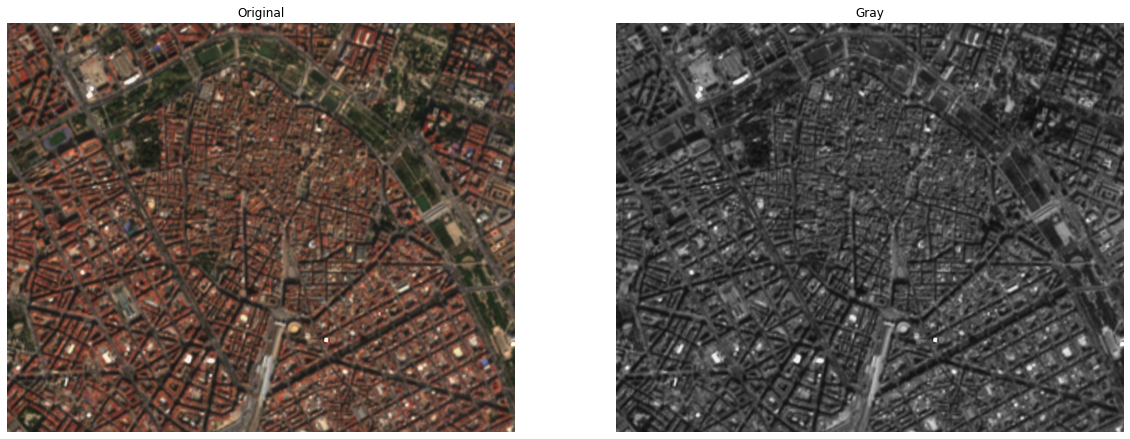

In [165]:
# Leemos imagen y convertimos a escala de grises
image_name = 'imagenes/vlc1b.png'
lp = plt.imread(image_name)#.astype('double')/255

lp_gray = rgb2gray(lp)

# comparamos img original e img con escala de grises
plot_comparison(lp,lp_gray,'Original', 'Gray')

In [ ]:
# Segmentadores: Felzenszwalb 

Se puede apreciar como un segmentador de este tipo no llega a realizar un buen trabajo en la separación de estos dos tipos de asentamiento dada la complejidad de la imagen. Se han probado diferentes configuraciones de las parámetros pero ninguna con gran éxito.

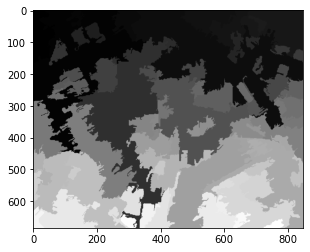

In [177]:

segments = felzenszwalb(image, scale=150.0, sigma=0.90, min_size=800)
plt.imshow(segments, cmap='gray')
plt.show()

# Segementadores: GLCM Texture Features

Se han decidido usar un segmentador de tipo GLCM porque se adapta mejor a las necesidades de este proyecto donde es necesario entrenar algo el clasificador para que sepa qué estamos buscando. En este caso se le indica al clasificador 3 puntos de cada zona, formal o atomística y se enseña como se entrenaria un modelo para utilizar estos parámetros. De esta manera podríamos clasificar más imagenes de la zona manteniendo los mismos parámetros.
Para cada punto calculamos sus valores de disimiliradad y de correlación y con ello se entrená el modelo. Se puede ver en la gráfica obtenida que los patrones obtenidos para cada tipo de asentamiento son muy diferentes, por lo que el clasificador debería de ser capaz de hacer un buen trabajo clasificando la imagen.

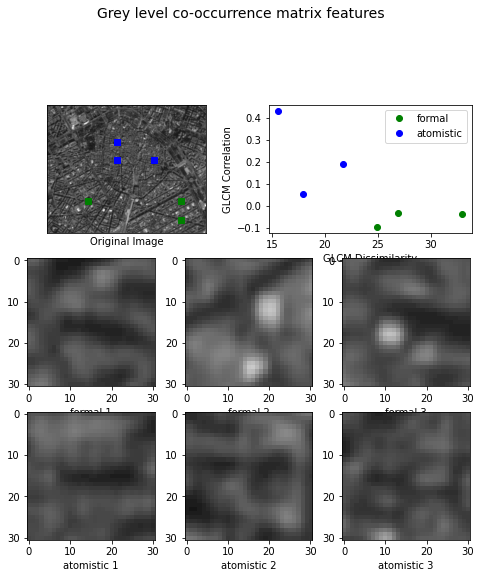

In [168]:

PATCH_SIZE = 31

# open the camera image
#  Float images are not supported by greycomatrix. Convert the image to an unsigned integer type
image=cv2.imread(image_name,0)

# select some patches from formaly areas of the image
formal_locations = [ (500,200), (500,700), (600,700)]
formal_patches = []
for loc in formal_locations:
    formal_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from atomistic areas of the image
atomistic_locations = [(280, 354), (180, 354), (280, 554)]
atomistic_patches = []
for loc in atomistic_locations:
    atomistic_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
distance = 10
xs = []
ys = []
xy = []
xy_formal = []

for patch in (formal_patches):
    glcm = greycomatrix(patch, distances=[distance], angles=[0], levels=256,
                        symmetric=True, normed=True)
    disValue = greycoprops(glcm, 'dissimilarity')[0, 0]
    corValue = greycoprops(glcm, 'correlation')[0, 0]                    
    xs.append(disValue)
    ys.append(corValue)
    xy.append([disValue, corValue])
    xy_formal.append([disValue, corValue])

xy_atomistic = []
for patch in (atomistic_patches):
    glcm = greycomatrix(patch, distances=[distance], angles=[0], levels=256,
                        symmetric=True, normed=True)
    disValue = greycoprops(glcm, 'dissimilarity')[0, 0]
    corValue = greycoprops(glcm, 'correlation')[0, 0]                    
    xs.append(disValue)
    ys.append(corValue)
    xy.append([disValue, corValue])
    xy_atomistic.append([disValue, corValue])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in formal_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in atomistic_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(formal_patches)], ys[:len(formal_patches)], 'go',
        label='formal')
ax.plot(xs[len(atomistic_patches):], ys[len(atomistic_patches):], 'bo',
        label='atomistic')
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(formal_patches):
    ax = fig.add_subplot(3, len(formal_patches), len(formal_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('formal %d' % (i + 1))

for i, patch in enumerate(atomistic_patches):
    ax = fig.add_subplot(3, len(atomistic_patches), len(atomistic_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel('atomistic %d' % (i + 1))


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

# Crear modelo

In [95]:
from sklearn import svm
import numpy as np


clf = svm.SVC()
print (xy_formal)
print (xy_atomistic)
clf.fit(xy_formal + xy_atomistic , [0,0,0,1,1,1])

[[30.58218125960062, -0.01899288719209487], [36.291858678955464, 0.0365586677654307], [32.87557603686637, -0.11147683481423919]]
[[23.960061443932414, 0.35664608307390533], [26.225806451612904, 0.03646386651841623], [20.281105990783402, -0.1472576826871734]]


SVC()

# Comparación

Se debería de crear un modelo para cada pixel utilizando el modelo entrenado con los datos de GLMC.

El modelo de ground truth a comparar sería el siguiente.


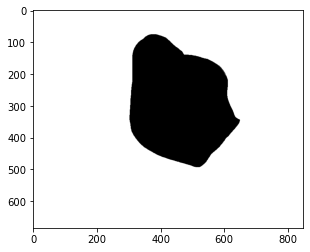

In [174]:
image_name_class = 'imagenes/vlc1b_class.png'
image_class=cv2.imread(image_name_class,0)
plt.imshow(image_class, cmap='gray')
plt.show()

# Segmentacion por K-Means

Este ejemplo para esta imagen da un resultado curioso, ya que es bastante bueno separando lo que son las carreteras de los edificios, permitiendo que se pudieran hacer otro tipo de operaciones sobre esta imagen para obtener mejores resultados en la separacion por tipo de asentamiento. No es apropiado para usarse directamente sobre tipos de asentamiento, pero podría ser el input de otro tipo de algoritmos para obtener los asentamiento de forma mas precisa eliminando mucha información innecesaria.


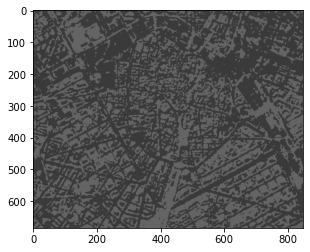

In [171]:
# https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
#convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()
segmented_image = centers[labels.flatten()]
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

# Conclusiones

Para obtener un buen funcionamiento de estos segmentadores es necesario realizar varias operaciones de union entre ellos ya que pequeños cambios en la imagen pueden afectar mucho los resultados. Hacer operaciones de desenfoque o de clusterización las veo necesarias para obtener imagenes más simplificadas que puedar ser una generalización de lo que buscamos y se pueda aplicar de la misma manera a otras imagenes sino se debería de ajustar el segementador para cada imagen independiente.

# Referencias

How to Use K-Means Clustering for Image Segmentation using OpenCV in Python, https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python

GLCM Texture Features, https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html